In [21]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt
from utils import optimize_channel

In [22]:
model_num = 1
phase = 'FF1'

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='finetune7')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

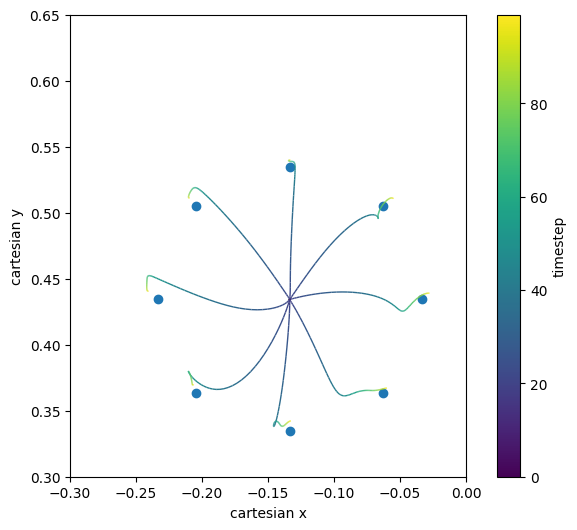

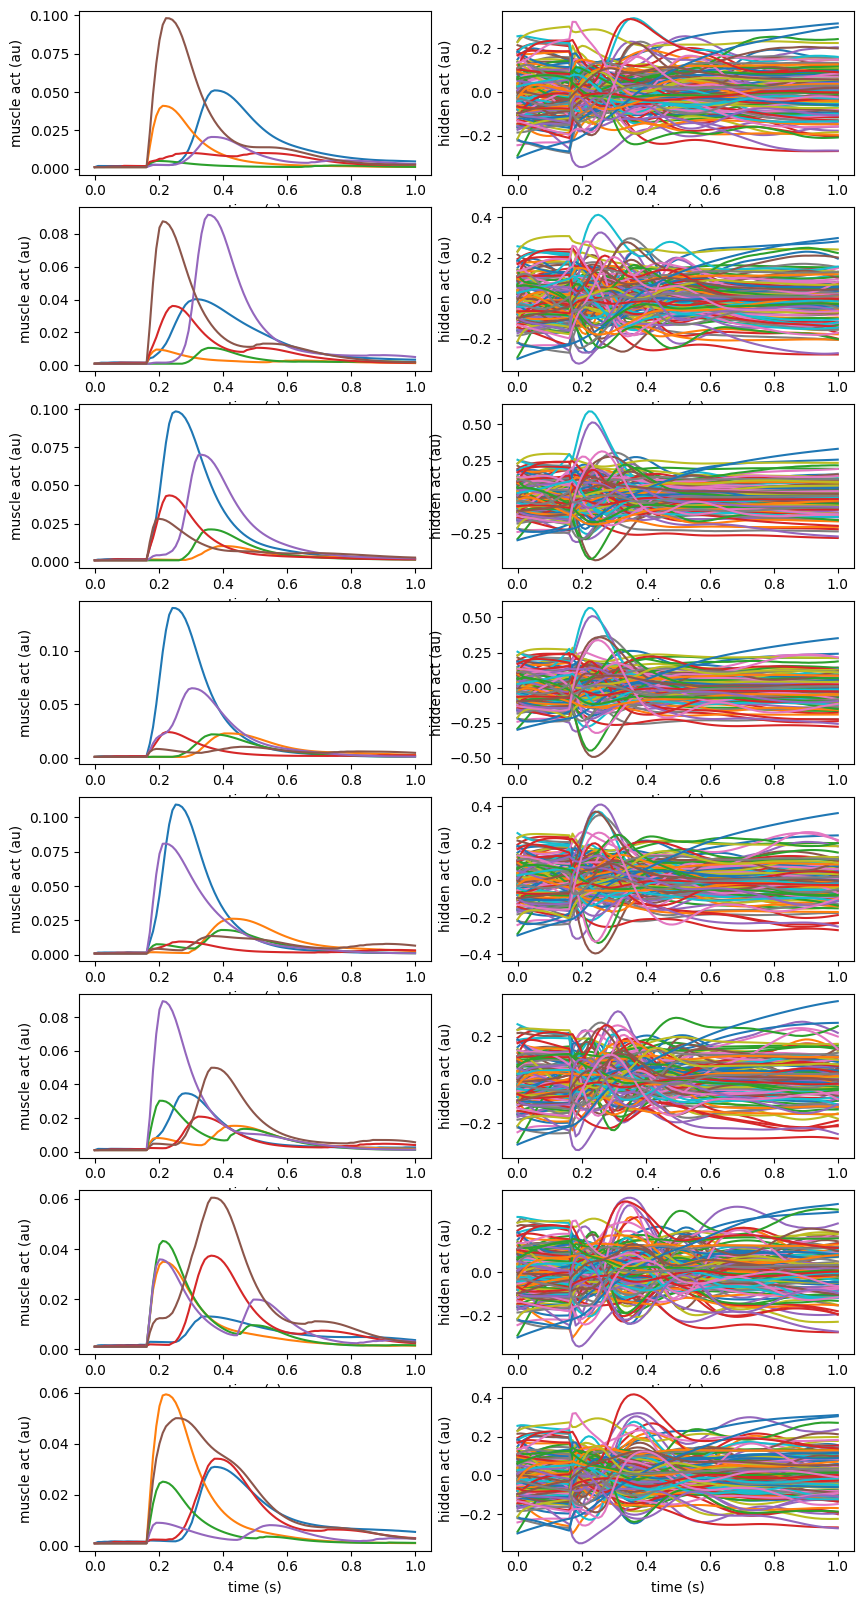

In [24]:
data = test(cfg_file,weight_file,ff_coefficient=8,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'],vel=None,plot_lat=False)
fig, ax = plot.plot_activation(data['all_hidden'],data['all_muscle'])

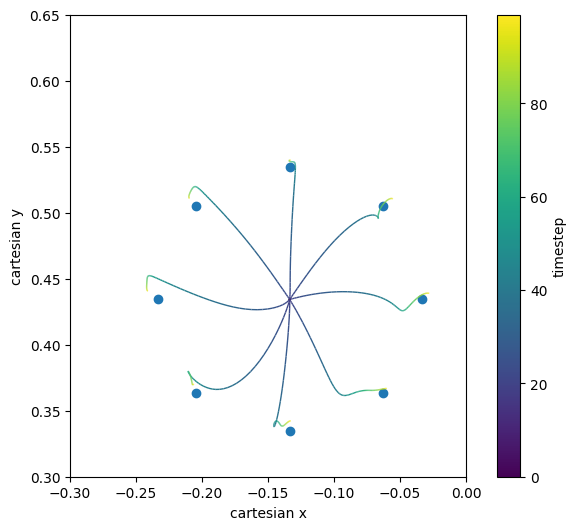

In [52]:
#theta = optimize_channel(cfg_file,weight_file)
data1 = test(cfg_file,weight_file,ff_coefficient=8,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=None,plot_lat=False)

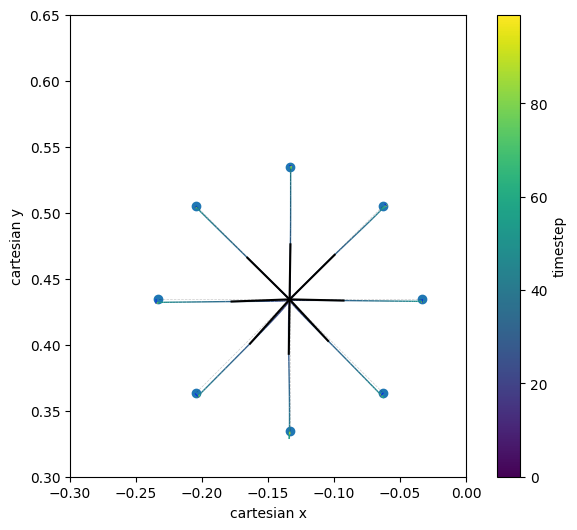

In [10]:
#theta = optimize_channel(cfg_file,weight_file)
K =  170
B = -1
data1 = test(cfg_file,weight_file,ff_coefficient=0,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data1['xy'],target_xy=data1['tg'], vel=data1['vel'],figsize=(8,6))

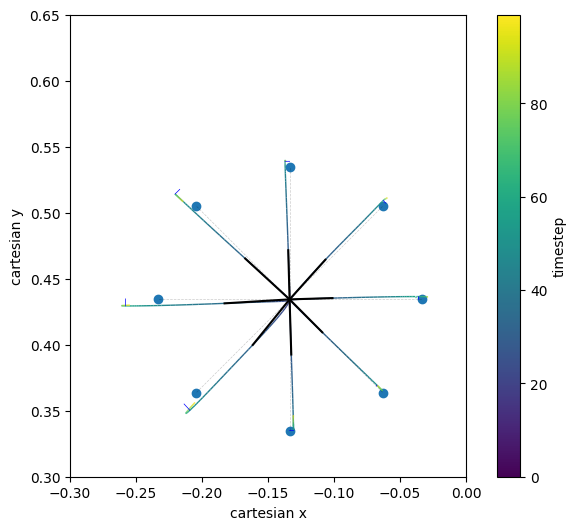

In [19]:
#theta = optimize_channel(cfg_file,weight_file)
K = 170
B = -1
data2 = test(cfg_file,weight_file,ff_coefficient=8,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data2['xy'],target_xy=data2['tg'], vel=data2['vel'],figsize=(8,6))

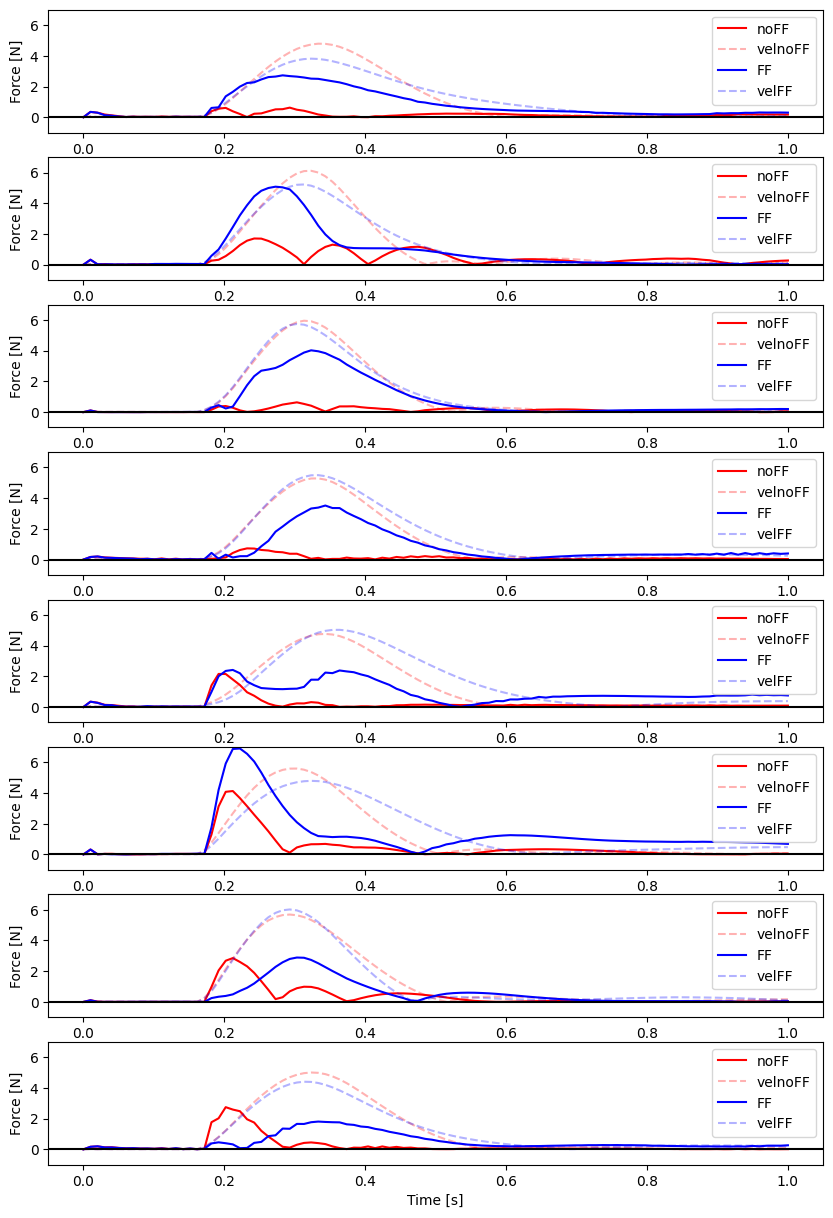

In [20]:
fig, ax = plot.plot_force(data1,data2=data2)